# Introduction to vector databases on S&P 500 news

 # 📌 Objectives

 By the end of this notebook, students will be able to:

 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.

 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.

 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.

 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.

 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.

 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.

 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [ ]:
%pip install sentence-transformers
%pip install faiss-cpu
%pip install yfinance

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss
import yfinance as yf
import seaborn as sns

## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [ ]:
# We define the directory where the data is located
from google.colab import drive
drive.mount('/content/drive')
import os
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/Fintech//Data"
os.chdir(DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_news = pd.read_csv('df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:

### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.

### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 Implement the class with the following methods (functions):

 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).

 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.

You will test your class at the end.

In [ ]:
# CODE HERE
# Use as many coding cells as you need

#Step 1: Prepare Documents
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' ' + df_news['SUMMARY']

#Step 2: Load Embedding Model
model = SentenceTransformer('all-MiniLM-L6-v2')

display(df_news.head())

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,EMBEDDED_TEXT
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,2 Dow Jones Stocks with Promising Prospects an...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,3 S&P 500 Stocks Skating on Thin Ice The S&P 5...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,3M Rises 15.8% YTD: Should You Buy the Stock N...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...,3 Cash-Producing Stocks with Questionable Fund...


In [ ]:
#Step 3: Defining CustomVectorStore Class
class CustomVectorStore:
    def __init__(self, model, documents, metadata):
        if len(documents) != len(metadata):
            raise ValueError("Number of documents and metadata entries must be the same.")
        self.model = model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = self.model.encode(documents)

    def search(self, query, k=5, metadata_filter=None):
        query_embedding = self.model.encode([query])

        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            filtered_embeddings = self.embeddings[filtered_indices]
            filtered_documents = [self.documents[i] for i in filtered_indices]
            filtered_metadata = [self.metadata[i] for i in filtered_indices]
        else:
            filtered_embeddings = self.embeddings
            filtered_documents = self.documents
            filtered_metadata = self.metadata
            filtered_indices = list(range(len(self.documents)))

        if len(filtered_embeddings) == 0:
            return []

        similarities = cosine_similarity(query_embedding, filtered_embeddings)[0]

        # Sorting by similarity in descending order and get top k indices within the filtered set
        top_k_indices_filtered = similarities.argsort()[-k:][::-1]

        # Map filtered indices back to original indices
        top_k_original_indices = [filtered_indices[i] for i in top_k_indices_filtered]

        results = []
        for i_filtered, i_original in zip(top_k_indices_filtered, top_k_original_indices):
             results.append((self.documents[i_original], self.metadata[i_original], similarities[i_filtered]))

        return results


## Create and populate the vector store

 👉 **Instructions**:
 - Convert the combined EMBEDDED_TEXT column into a list of strings.
 - Create a metadata list of dictionaries for each document with keys:
   - 'PUBLICATION_DATE'
   - 'TICKER'
   - 'PROVIDER'
 - Instantiate your CustomVectorStore using:
   - The embedding model.
   - The list of document strings.
   - The metadata list.

 After initializing the store, you should be able to perform searches using:
'store.search("Apple earnings", k=3)'


In [ ]:
# CODE HERE
# Use as many coding cells as you need

# Converting the combined EMBEDDED_TEXT column into a list of strings
documents = df_news['EMBEDDED_TEXT'].tolist()

# Creating metadata list of dictionaries
metadata = df_news[['PUBLICATION_DATE', 'TICKER', 'PROVIDER']].to_dict('records')

# Instantiating CustomVectorStore
store = CustomVectorStore(model, documents, metadata)

print("CustomVectorStore instantiated successfully.")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


CustomVectorStore instantiated successfully.


In [ ]:
# Performing first search
query1 = "Apple earnings"
results1 = store.search(query1, k=3)

print(f"Top 3 results for query: '{query1}'")
for doc, meta, score in results1:
    print(f"  Score: {score:.4f}, Ticker: {meta['TICKER']}, Date: {meta['PUBLICATION_DATE']}, Provider: {meta['PROVIDER']}")
    print(f"  Document: {doc[:200]}...\n") # Print first 200 characters

# Perform second search
query2 = "Stock split"
results2 = store.search(query2, k=5)

print(f"Top 5 results for query: '{query2}'")
for doc, meta, score in results2:
    print(f"  Score: {score:.4f}, Ticker: {meta['TICKER']}, Date: {meta['PUBLICATION_DATE']}, Provider: {meta['PROVIDER']}")
    print(f"  Document: {doc[:200]}...\n") # Print first 200 characters

Top 3 results for query: 'Apple earnings'
  Score: 0.5717, Ticker: APTV, Date: 2025-05-01, Provider: Barrons.com
  Document: Aptiv Stock Rises. Earnings Were Great, But Tariff Impact Is Still Uncertain. Thursday morning, Aptiv reported first-quarter earnings per share of $1.69 from sales of $4.8 billion in sales. Wall Stree...

  Score: 0.5701, Ticker: OKE, Date: 2025-04-30, Provider: Simply Wall St.
  Document: ONEOK (NYSE:OKE) Reports Q1 2025 Revenue Surge to US$8 Billion ONEOK (NYSE:OKE) recently released its first-quarter earnings, reporting revenue of USD 8,043 million, a marked increase year-over-year, ...

  Score: 0.5675, Ticker: HUM, Date: 2025-05-28, Provider: Simply Wall St.
  Document: Humana (NYSE:HUM) Sees Revenue Increase in First-Quarter Earnings to US$32,112 Million Humana (NYSE:HUM) recently reported first-quarter earnings, showcasing a revenue increase from USD 29,611 million...



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Top 5 results for query: 'Stock split'
  Score: 0.7261, Ticker: NFLX, Date: 2025-05-30, Provider: Motley Fool
  Document: 1 Potential Stock-Split Stock to Buy Hand Over Fist in June, and 1 Stock-Split Stock to Avoid These headline-making moves can certainly create a bullish buzz, but that doesn't mean they always last....

  Score: 0.7261, Ticker: KO, Date: 2025-05-30, Provider: Motley Fool
  Document: 1 Potential Stock-Split Stock to Buy Hand Over Fist in June, and 1 Stock-Split Stock to Avoid These headline-making moves can certainly create a bullish buzz, but that doesn't mean they always last....

  Score: 0.7054, Ticker: FAST, Date: 2025-05-22, Provider: Motley Fool
  Document: Wall Street's Newest Stock-Split Stock Has Arrived -- and Its Shares Have Rocketed Higher by 214,200% Since Its IPO This marks the ninth time in 37 years this unstoppable company has completed a forwa...

  Score: 0.7054, Ticker: ORLY, Date: 2025-05-22, Provider: Motley Fool
  Document: Wall Street's Newest

## Using your vector store and analyzing the results

### Retrieve AI Announcements

 Now that your vector store is working, let's use it to retrieve relevant documents.

 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text


In [ ]:
# CODE HERE
# Use as many coding cells as you need

query = "AI announcement"
k = 50

results = store.search(query, k=k)

# Displaying each result's information
print(f"Top {k} results for query: '{query}'")
for i, (doc, meta, score) in enumerate(results, 1):
    print(f"{i}. Score: {score:.4f}, Ticker: {meta['TICKER']}, Date: {meta['PUBLICATION_DATE']}, Provider: {meta['PROVIDER']}")
    print(f"  Document: {doc}\n")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Top 50 results for query: 'AI announcement'
1. Score: 0.5567, Ticker: ADBE, Date: 2025-05-27, Provider: Investor's Business Daily
  Document: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.

2. Score: 0.5467, Ticker: JKHY, Date: 2025-03-17, Provider: Insider Monkey
  Document: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]

3. Score: 0.5353, Ticker: PLTR, Date: 2025-05-31, Provider: Motley Fool
  Document: Better Artificial Intelligence (AI) Stock: Palantir vs. Snowflake Shares of 

 ### **Q1.** What are the top companies (by TICKER) most frequently appearing in the top 50 search results for the query "AI announcement"?  
 Check their company names on Yahoo Finance. Are you surprised by the results?

 ✅ **Your task**:
 - Count the number of times each TICKER appears.
 - Print and analyze the top results.

In [ ]:
# CODE HERE
# Use as many coding cells as you need

# Extracting tickers from the results
tickers = [meta['TICKER'] for doc, meta, score in results]

# Counting the frequency of each ticker
ticker_counts = Counter(tickers)

# Displaying the top tickers
print("Top 10 stock companies by frequency in the top 50 results:")
for ticker, count in ticker_counts.most_common(10):
    print(f"  {ticker}: {count}")

Top 10 stock companies by frequency in the top 50 results:
  PLTR: 5
  BKR: 3
  AMD: 3
  CTSH: 3
  QCOM: 2
  META: 2
  AMZN: 2
  MSFT: 2
  EXPE: 2
  INTC: 2


In [ ]:
# Listing of top 10 tickers
top_10_tickers = ['PLTR', 'BKR', 'AMD', 'CTSH', 'QCOM', 'META', 'AMZN', 'MSFT', 'EXPE', 'INTC']

print("Company names for the top 10 tickers:")
for ticker in top_10_tickers:
    try:
        stock = yf.Ticker(ticker)
        company_info = stock.info
        company_name = company_info.get('longName', 'N/A')
        print(f"  {ticker}: {company_name}")
    except Exception as e:
        print(f"  Could not retrieve information for {ticker}: {e}")

Company names for the top 10 tickers:
  PLTR: Palantir Technologies Inc.
  BKR: Baker Hughes Company
  AMD: Advanced Micro Devices, Inc.
  CTSH: Cognizant Technology Solutions Corporation
  QCOM: QUALCOMM Incorporated
  META: Meta Platforms, Inc.
  AMZN: Amazon.com, Inc.
  MSFT: Microsoft Corporation
  EXPE: Expedia Group, Inc.
  INTC: Intel Corporation


YOUR WRITTEN RESPONSE HERE:
Yes, I am surprised by the results because I am not familiar with the first two companies listed: Palantir Technologies Inc. (PLTR) and Baker Hughes Company (BKR). I would have expected to see companies more commonly associated with AI at the very top of the list

### **Q2.** What is the date range of the top 50 results? Are the articles evenly distributed across time?

 ✅ **Your task**:
 - Extract the publication dates of the top 50 results.
 - Plot a histogram to visualize the temporal distribution.
 - Reflect: Are these mentions clustered in recent months or spread evenly?

 🧠 **Follow-up**: What could explain the timing of increased AI announcements?

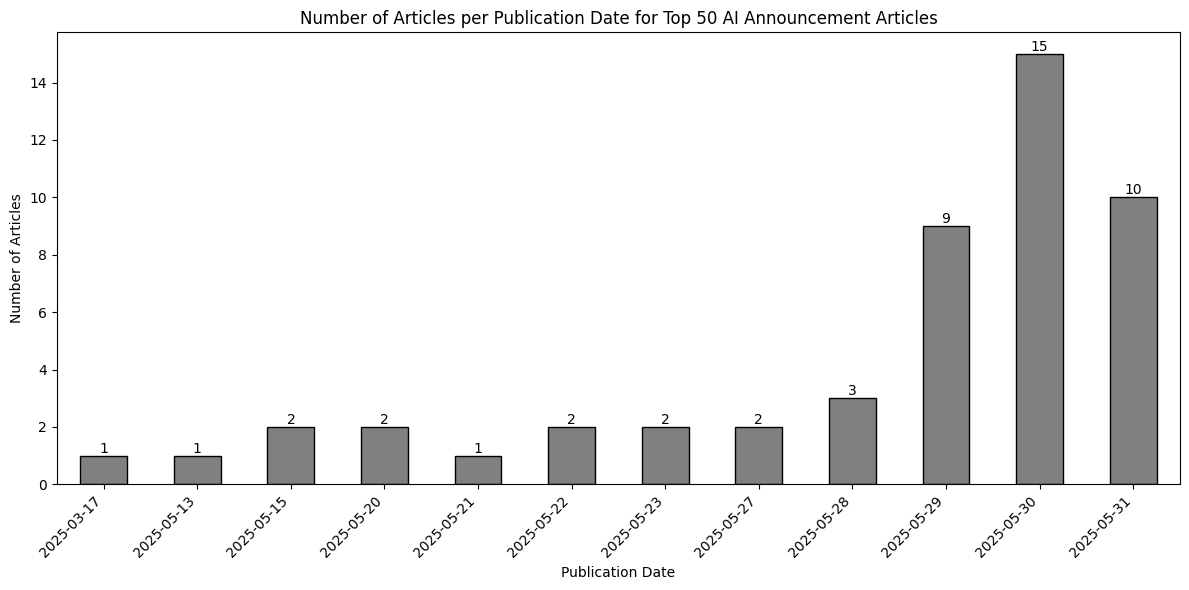


Date range of the top 50 results: 2025-03-17 to 2025-05-31


In [ ]:
# CODE HERE
# Use as many coding cells as you need

# Extracting publication dates from the results
publication_dates = [meta['PUBLICATION_DATE'] for doc, meta, score in results]

# Converting dates to datetime objects for plotting
publication_dates_dt = pd.to_datetime(publication_dates)

# Counting the number of articles per date
date_counts = pd.Series(publication_dates).value_counts().sort_index()

# Plotting a bar chart of the publication dates
plt.figure(figsize=(12, 6))
ax = date_counts.plot(kind='bar', edgecolor='black', color='gray')
plt.title('Number of Articles per Publication Date for Top 50 AI Announcement Articles')
plt.xlabel('Publication Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Adding counts on top of each bar
for container in ax.containers:
    ax.bar_label(container)

plt.show()

# Print the date range
min_date = min(publication_dates)
max_date = max(publication_dates)
print(f"\nDate range of the top 50 results: {min_date} to {max_date}")

YOUR WRITTEN RESPONSE HERE
* What is the date range of the top 50 results?
  * From March 17,2025 to May 31, 2025
* Are the articles evenly distributed across time?
  * They are not distributed across the time.


## Implement FAISS vector store

 We’ll now implement a **FAISS-based vector store**, designed for efficient similarity search at scale.

 👉 **Steps**:
 - Use the same sentence transformer model: all-MiniLM-L6-v2.
 - Encode your text into embessings
 - Normalize the vectors.

 FAISS supports multiple similarity types. For cosine similarity, we must:

 ✅ Normalize vectors to unit length  
 ✅ Use `IndexFlatIP` (inner product), because:
 - For normalized vectors, inner product = cosine similarity


In [ ]:
# CODE HERE
# Use as many coding cells as you need

# Since we already have the same sentence transformer model and encode the text
# The model is already loaded in a previous cell as 'model'
faiss_embeddings = model.encode(documents)

# Normalizing the vectors
faiss_embeddings = faiss_embeddings.astype('float32')
faiss.normalize_L2(faiss_embeddings)

print("Embeddings encoded and normalized for FAISS.")
print(f"Shape of FAISS embeddings: {faiss_embeddings.shape}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Embeddings encoded and normalized for FAISS.
Shape of FAISS embeddings: (4871, 384)


We’ll now:
 - Initialize the FAISS index
 - Add the document embeddings

In [ ]:
# CODE HERE
# Use as many coding cells as you need

# Initializing the FAISS index using IndexFlatIP (for cosine similarity with normalized vectors)
dimension = faiss_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)

# Adding the document embeddings to the index
index.add(faiss_embeddings)

print(f"FAISS index created with dimension {dimension}.")
print(f"Number of vectors in the index: {index.ntotal}")


FAISS index created with dimension 384.
Number of vectors in the index: 4871


### Create a `FaissVectorStore` class with a `.search()` method.

 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata

In [ ]:
# CODE HERE
# Use as many coding cells as you need

class FaissVectorStore:
    def __init__(self, index, model, documents, metadata):
        self.index = index
        self.model = model
        self.documents = documents
        self.metadata = metadata
        self.dimension = index.d

    def search(self, query, k=5, metadata_filter=None):
        query_embedding = self.model.encode([query])
        query_embedding = query_embedding.astype('float32')
        faiss.normalize_L2(query_embedding)

        if metadata_filter:
            distances, indices = self.index.search(query_embedding, len(self.documents))

            # Filtering results based on metadata and collect original indices and their corresponding distances
            filtered_indices_with_distances = []
            for i, original_index in enumerate(indices[0]):
                if metadata_filter(self.metadata[original_index]):
                    filtered_indices_with_distances.append((original_index, distances[0][i]))

            filtered_indices_with_distances.sort(key=lambda x: x[1], reverse=True)

            results = []
            for original_index, score in filtered_indices_with_distances[:k]:
                 results.append((self.documents[original_index], self.metadata[original_index], score))

            return results

        else:

            distances, indices = self.index.search(query_embedding, k)

            results = []
            for i in range(k):
                original_index = indices[0][i]
                score = distances[0][i]
                results.append((self.documents[original_index], self.metadata[original_index], score))
            return results

 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`

 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text

In [ ]:
# CODE HERE
# Use as many coding cells as you need

# Instantiating the FaissVectorStore
faiss_store = FaissVectorStore(index, model, documents, metadata)

# Running a semantic search using FAISS
query = "AI announcement"
k = 50
faiss_results = faiss_store.search(query, k=k)

# Printing out the details of the results
print(f"Top {k} results for query: '{query}' using FAISS:")
for i, (doc, meta, score) in enumerate(faiss_results, 1):
    print(f"{i}. Similarity score: {score:.4f}, Ticker: {meta['TICKER']}, Date: {meta['PUBLICATION_DATE']}, Provider: {meta['PROVIDER']}")
    print(f"  Document: {doc}\n")

Top 50 results for query: 'AI announcement' using FAISS:
1. Similarity score: 0.5567, Ticker: ADBE, Date: 2025-05-27, Provider: Investor's Business Daily
  Document: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.

2. Similarity score: 0.5467, Ticker: JKHY, Date: 2025-03-17, Provider: Insider Monkey
  Document: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]

3. Similarity score: 0.5353, Ticker: PLTR, Date: 2025-05-31, Provider: Motley Fool
  Document: Better Artificial Intelligence

## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:

 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [ ]:
# CODE HERE
# Use as many coding cells as you need

test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation',
    'Cryptocurrency'
]

k = 5

for query in test_queries:
    print(f"--- Results for Query: '{query}' ---")

    print("\nCustom Vector Store Results:")
    custom_results = store.search(query, k=k)
    if custom_results:
        for i, (doc, meta, score) in enumerate(custom_results, 1):
            print(f"  {i}. Score: {score:.4f}, Ticker: {meta['TICKER']}, Date: {meta['PUBLICATION_DATE']}, Provider: {meta['PROVIDER']}")
            print(f"     Document: {doc[:150]}...")
    else:
        print("  No results found.")

    print("\nFAISS Vector Store Results:")
    faiss_results = faiss_store.search(query, k=k)
    if faiss_results:
        for i, (doc, meta, score) in enumerate(faiss_results, 1):
            print(f"  {i}. Score: {score:.4f}, Ticker: {meta['TICKER']}, Date: {meta['PUBLICATION_DATE']}, Provider: {meta['PROVIDER']}")
            print(f"     Document: {doc[:150]}...")
    else:
        print("  No results found.")

    print("-" * (len(query) + 25))


--- Results for Query: 'Stock price drop' ---

Custom Vector Store Results:
  1. Score: 0.5706, Ticker: PKG, Date: 2025-05-29, Provider: StockStory
     Document: 3 Reasons to Avoid PKG and 1 Stock to Buy Instead Packaging Corporation of America has gotten torched over the last six months - since November 2024, ...
  2. Score: 0.5700, Ticker: HUM, Date: 2025-05-27, Provider: StockStory
     Document: 2 Reasons to Like HUM and 1 to Stay Skeptical Humana has gotten torched over the last six months - since November 2024, its stock price has dropped 24...
  3. Score: 0.5533, Ticker: CRL, Date: 2025-05-21, Provider: StockStory
     Document: Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, What You Need To Know A number of stocks fell in th...
  4. Score: 0.5483, Ticker: GNRC, Date: 2025-05-28, Provider: StockStory
     Document: 3 Industrials Stocks Walking a Fine Line Even if they go mostly unnoticed, industrial businesses are the backbone

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  1. Score: 0.5593, Ticker: CVX, Date: 2025-05-30, Provider: Fox Business
     Document: Chevron to layoff approximately 200 employees in Texas in 2025 Chevron plans to lay off 200 employees at locations in Midland, Texas as part of a glob...
  2. Score: 0.5369, Ticker: FDX, Date: 2025-05-29, Provider: Sourcing Journal
     Document: FedEx Plans More Than 300 Layoffs At Texas Facility The logistics giant said impacted workers may be offered other positions with the company....
  3. Score: 0.4737, Ticker: CVX, Date: 2025-05-29, Provider: Offshore Technology
     Document: Chevron to implement around 800 job cuts in Texas Chevron previously disclosed plans to lay off 600 California workers starting on 1 June, according t...
  4. Score: 0.4401, Ticker: CVX, Date: 2025-05-30, Provider: Hart Energy
     Document: Chevron Confirms 200 Permian Layoffs—Not 800 Chevron has confirmed the Texas Workforce Commission mistakenly reported the number of layoffs in Midland...
  5. Score: 0.4328, Ticker

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  1. Score: 0.5593, Ticker: CVX, Date: 2025-05-30, Provider: Fox Business
     Document: Chevron to layoff approximately 200 employees in Texas in 2025 Chevron plans to lay off 200 employees at locations in Midland, Texas as part of a glob...
  2. Score: 0.5369, Ticker: FDX, Date: 2025-05-29, Provider: Sourcing Journal
     Document: FedEx Plans More Than 300 Layoffs At Texas Facility The logistics giant said impacted workers may be offered other positions with the company....
  3. Score: 0.4737, Ticker: CVX, Date: 2025-05-29, Provider: Offshore Technology
     Document: Chevron to implement around 800 job cuts in Texas Chevron previously disclosed plans to lay off 600 California workers starting on 1 June, according t...
  4. Score: 0.4401, Ticker: CVX, Date: 2025-05-30, Provider: Hart Energy
     Document: Chevron Confirms 200 Permian Layoffs—Not 800 Chevron has confirmed the Texas Workforce Commission mistakenly reported the number of layoffs in Midland...
  5. Score: 0.4328, Ticker

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  1. Score: 0.5672, Ticker: KEY, Date: 2025-05-31, Provider: Motley Fool
     Document: 2 Large Regional Bank Stocks That Could Get Acquired During the Trump Administration Mergers and acquisitions (M&A) could pick up in the banking secto...
  2. Score: 0.4999, Ticker: STE, Date: 2025-05-21, Provider: Zacks
     Document: AST Business Growth & Strategic Acquisitions Support STERIS Stock STE frequently engages in strategic acquisitions and joint ventures to optimize its ...
  3. Score: 0.4927, Ticker: COF, Date: 2025-05-27, Provider: Zacks
     Document: COF Stock Tanks 5.9% Post Discover Merger: A Good Buying Opportunity? COF shares have dipped 5.9% since the Discover deal. Can loan growth, merger syn...
  4. Score: 0.4829, Ticker: TTWO, Date: 2025-05-21, Provider: Simply Wall St.
     Document: Take-Two Interactive Software (NasdaqGS:TTWO) Pursues Acquisitions with US$1B Equity Offering Take-Two Interactive Software (NasdaqGS:TTWO) recently p...
  5. Score: 0.4563, Ticker: SNPS, Date:

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  1. Score: 0.4224, Ticker: DOC, Date: 2024-09-13, Provider: Yahoo Finance Video
     Document: How the 10-year yield affects REITs Interest rate-sensitive REITs (Real Estate Investment Trusts) are set to benefit from the Federal Reserve's antici...
  2. Score: 0.4176, Ticker: NEM, Date: 2025-05-28, Provider: TipRanks
     Document: NEM, FNV, and WPM Primed for Gold Rush 2.0 as Geopolitics Fuel Hard Asset Boom Amid rising geopolitical tensions, persistent inflation concerns, and g...
  3. Score: 0.4160, Ticker: BLK, Date: 2025-05-29, Provider: Yahoo Finance UK
     Document: Bitcoin price slips as Fed minutes flag US inflation risks The Federal Reserve’s May policy meeting revealed mounting concern over persistent US infla...
  4. Score: 0.4120, Ticker: AWK, Date: 2025-05-08, Provider: Zacks
     Document: Fed Leaves Interest Rates Unchanged: 4 Low-Beta Utility Stocks to Buy Markets are likely to remain volatile. Utility stocks, which are considered defe...
  5. Score: 0.4120, Ticker: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  1. Score: 0.3945, Ticker: BK, Date: 2025-05-15, Provider: Financial Times
     Document: US poised to dial back bank rules imposed in wake of 2008 crisis US authorities are preparing to announce one of the biggest cuts in banks’ capital re...
  2. Score: 0.3358, Ticker: NSC, Date: 2025-05-21, Provider: FreightWaves
     Document: Regulatory risk a red signal to rail mergers, investors told Railroad executives told an investors conference that future mergers face likely insurmou...
  3. Score: 0.3300, Ticker: IT, Date: 2025-05-27, Provider: CFO.com
     Document: Gartner’s Alex Bant breaks down the new realities of CFO leadership Bant explains how CFOs can make better decisions, challenge the single source of t...
  4. Score: 0.3124, Ticker: SO, Date: 2025-05-20, Provider: Zacks
     Document: SO Reaches a Settlement for Extension of Rate Plan Through 2028 The Southern Company and state regulators agree to extend stable retail rates through ...
  5. Score: 0.3050, Ticker: SNPS, Date: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

YOUR WRITTEN RESPONSE HERE:
* No differences are perceived between both models, at least not in the first 5 records.

## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:

 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [ ]:
# CODE HERE
# Use as many coding cells as you need

# Loading the second embedding model
model_mpnet = SentenceTransformer('all-mpnet-base-v2')
print("Loaded 'all-mpnet-base-v2' model.")

# Instantiating a new CustomVectorStore with the second model
store_mpnet = CustomVectorStore(model_mpnet, documents, metadata)
print("CustomVectorStore instantiated with 'all-mpnet-base-v2' model.")

Loaded 'all-mpnet-base-v2' model.
CustomVectorStore instantiated with 'all-mpnet-base-v2' model.


In [ ]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation',
    'Cryptocurrency'
]

k = 5

for query in test_queries:
    print(f"--- Comparing Models for Query: '{query}' ---")

    print("\nCustom Vector Store ('all-MiniLM-L6-v2') Results:")
    custom_results_minilm = store.search(query, k=k)
    if custom_results_minilm:
        for i, (doc, meta, score) in enumerate(custom_results_minilm, 1):
            print(f"  {i}. Score: {score:.4f}, Ticker: {meta['TICKER']}, Date: {meta['PUBLICATION_DATE']}, Provider: {meta['PROVIDER']}")
            print(f"     Document: {doc[:150]}...")
    else:
        print("  No results found.")

    print("\nCustom Vector Store ('all-mpnet-base-v2') Results:")
    custom_results_mpnet = store_mpnet.search(query, k=k)
    if custom_results_mpnet:
        for i, (doc, meta, score) in enumerate(custom_results_mpnet, 1):
            print(f"  {i}. Score: {score:.4f}, Ticker: {meta['TICKER']}, Date: {meta['PUBLICATION_DATE']}, Provider: {meta['PROVIDER']}")
            print(f"     Document: {doc[:150]}...")
    else:
        print("  No results found.")

    print("-" * (len(query) + 30))

--- Comparing Models for Query: 'Stock price drop' ---

Custom Vector Store ('all-MiniLM-L6-v2') Results:
  1. Score: 0.5706, Ticker: PKG, Date: 2025-05-29, Provider: StockStory
     Document: 3 Reasons to Avoid PKG and 1 Stock to Buy Instead Packaging Corporation of America has gotten torched over the last six months - since November 2024, ...
  2. Score: 0.5700, Ticker: HUM, Date: 2025-05-27, Provider: StockStory
     Document: 2 Reasons to Like HUM and 1 to Stay Skeptical Humana has gotten torched over the last six months - since November 2024, its stock price has dropped 24...
  3. Score: 0.5533, Ticker: CRL, Date: 2025-05-21, Provider: StockStory
     Document: Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, What You Need To Know A number of stocks fell in th...
  4. Score: 0.5483, Ticker: GNRC, Date: 2025-05-28, Provider: StockStory
     Document: 3 Industrials Stocks Walking a Fine Line Even if they go mostly unnoticed, industri

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  1. Score: 0.5593, Ticker: CVX, Date: 2025-05-30, Provider: Fox Business
     Document: Chevron to layoff approximately 200 employees in Texas in 2025 Chevron plans to lay off 200 employees at locations in Midland, Texas as part of a glob...
  2. Score: 0.5369, Ticker: FDX, Date: 2025-05-29, Provider: Sourcing Journal
     Document: FedEx Plans More Than 300 Layoffs At Texas Facility The logistics giant said impacted workers may be offered other positions with the company....
  3. Score: 0.4737, Ticker: CVX, Date: 2025-05-29, Provider: Offshore Technology
     Document: Chevron to implement around 800 job cuts in Texas Chevron previously disclosed plans to lay off 600 California workers starting on 1 June, according t...
  4. Score: 0.4401, Ticker: CVX, Date: 2025-05-30, Provider: Hart Energy
     Document: Chevron Confirms 200 Permian Layoffs—Not 800 Chevron has confirmed the Texas Workforce Commission mistakenly reported the number of layoffs in Midland...
  5. Score: 0.4328, Ticker

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  1. Score: 0.5672, Ticker: KEY, Date: 2025-05-31, Provider: Motley Fool
     Document: 2 Large Regional Bank Stocks That Could Get Acquired During the Trump Administration Mergers and acquisitions (M&A) could pick up in the banking secto...
  2. Score: 0.4999, Ticker: STE, Date: 2025-05-21, Provider: Zacks
     Document: AST Business Growth & Strategic Acquisitions Support STERIS Stock STE frequently engages in strategic acquisitions and joint ventures to optimize its ...
  3. Score: 0.4927, Ticker: COF, Date: 2025-05-27, Provider: Zacks
     Document: COF Stock Tanks 5.9% Post Discover Merger: A Good Buying Opportunity? COF shares have dipped 5.9% since the Discover deal. Can loan growth, merger syn...
  4. Score: 0.4829, Ticker: TTWO, Date: 2025-05-21, Provider: Simply Wall St.
     Document: Take-Two Interactive Software (NasdaqGS:TTWO) Pursues Acquisitions with US$1B Equity Offering Take-Two Interactive Software (NasdaqGS:TTWO) recently p...
  5. Score: 0.4563, Ticker: ANSS, Date:

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  1. Score: 0.4224, Ticker: DOC, Date: 2024-09-13, Provider: Yahoo Finance Video
     Document: How the 10-year yield affects REITs Interest rate-sensitive REITs (Real Estate Investment Trusts) are set to benefit from the Federal Reserve's antici...
  2. Score: 0.4176, Ticker: NEM, Date: 2025-05-28, Provider: TipRanks
     Document: NEM, FNV, and WPM Primed for Gold Rush 2.0 as Geopolitics Fuel Hard Asset Boom Amid rising geopolitical tensions, persistent inflation concerns, and g...
  3. Score: 0.4160, Ticker: BLK, Date: 2025-05-29, Provider: Yahoo Finance UK
     Document: Bitcoin price slips as Fed minutes flag US inflation risks The Federal Reserve’s May policy meeting revealed mounting concern over persistent US infla...
  4. Score: 0.4120, Ticker: AES, Date: 2025-05-08, Provider: Zacks
     Document: Fed Leaves Interest Rates Unchanged: 4 Low-Beta Utility Stocks to Buy Markets are likely to remain volatile. Utility stocks, which are considered defe...
  5. Score: 0.4120, Ticker: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  1. Score: 0.3945, Ticker: BK, Date: 2025-05-15, Provider: Financial Times
     Document: US poised to dial back bank rules imposed in wake of 2008 crisis US authorities are preparing to announce one of the biggest cuts in banks’ capital re...
  2. Score: 0.3358, Ticker: NSC, Date: 2025-05-21, Provider: FreightWaves
     Document: Regulatory risk a red signal to rail mergers, investors told Railroad executives told an investors conference that future mergers face likely insurmou...
  3. Score: 0.3300, Ticker: IT, Date: 2025-05-27, Provider: CFO.com
     Document: Gartner’s Alex Bant breaks down the new realities of CFO leadership Bant explains how CFOs can make better decisions, challenge the single source of t...
  4. Score: 0.3124, Ticker: SO, Date: 2025-05-20, Provider: Zacks
     Document: SO Reaches a Settlement for Extension of Rate Plan Through 2028 The Southern Company and state regulators agree to extend stable retail rates through ...
  5. Score: 0.3050, Ticker: SNPS, Date: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


  1. Score: 0.5571, Ticker: PYPL, Date: 2025-05-27, Provider: Zacks
     Document: 3 Crypto-Centric Stocks in Focus as Bitcoin Resumes Its Rally Bitcoin hovers near $110K as crypto sentiment surges. V, PYPL, and CLSK emerge as top st...
  2. Score: 0.5036, Ticker: COIN, Date: 2025-05-28, Provider: Investor's Business Daily
     Document: Cryptocurrency Prices And News: Bitcoin Hovers Near Record High, Miners Join Rally Cryptocurrency News:  Cryptocurrency prices have been mixed this we...
  3. Score: 0.4287, Ticker: COIN, Date: 2025-05-28, Provider: Barrons.com
     Document: Bitcoin Price Falls. Key Crypto Conference Fails to Lift Digital Coins. Bitcoin’s  price edged down despite a flurry of crypto news, including an endo...
  4. Score: 0.4092, Ticker: COIN, Date: 2025-05-27, Provider: Barrons.com
     Document: Robinhood vs. Coinbase: Why One Stock Is a Much Bigger Winner The boom in Bitcoin is driving both stocks. But Robinhood is on a meteoric rise because ...
  5. Score: 0.3712, 

In [ ]:
comparison_data = []

for query in test_queries:
    # Getting results from the Custom Vector Store with all-MiniLM-L6-v2
    custom_results_minilm = store.search(query, k=k)
    for i, (doc, meta, score) in enumerate(custom_results_minilm, 1):
        comparison_data.append({
            'Model': 'all-MiniLM-L6-v2',
            'Query': query,
            'Rank': i,
            'Score': score,
            'Ticker': meta['TICKER'],
            'Date': meta['PUBLICATION_DATE'],
        })

    # Getting results from the Custom Vector Store with all-mpnet-base-v2
    custom_results_mpnet = store_mpnet.search(query, k=k)
    for i, (doc, meta, score) in enumerate(custom_results_mpnet, 1):
        comparison_data.append({
            'Model': 'all-mpnet-base-v2',
            'Query': query,
            'Rank': i,
            'Score': score,
            'Ticker': meta['TICKER'],
            'Date': meta['PUBLICATION_DATE'],
        })

# Creating a pandas DataFrame from the collected data
comparison_df = pd.DataFrame(comparison_data)

# Displaying the DataFrame
display(comparison_df)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

,Model,Query,Rank,Score,Ticker,Date
0,all-MiniLM-L6-v2,Stock price drop,1,0.570610,PKG,2025-05-29
1,all-MiniLM-L6-v2,Stock price drop,2,0.570009,HUM,2025-05-27
2,all-MiniLM-L6-v2,Stock price drop,3,0.553263,CRL,2025-05-21
3,all-MiniLM-L6-v2,Stock price drop,4,0.548273,GNRC,2025-05-28
4,all-MiniLM-L6-v2,Stock price drop,5,0.544070,KR,2025-05-27
5,all-mpnet-base-v2,Stock price drop,1,0.594263,HPQ,2025-05-29
6,all-mpnet-base-v2,Stock price drop,2,0.580671,IVZ,2025-05-05
7,all-mpnet-base-v2,Stock price drop,3,0.576523,CRL,2025-05-21
8,all-mpnet-base-v2,Stock price drop,4,0.568019,SBUX,2025-05-29
9,all-mpnet-base-v2,Stock price drop,5,0.565543,UBER,2025-05-30


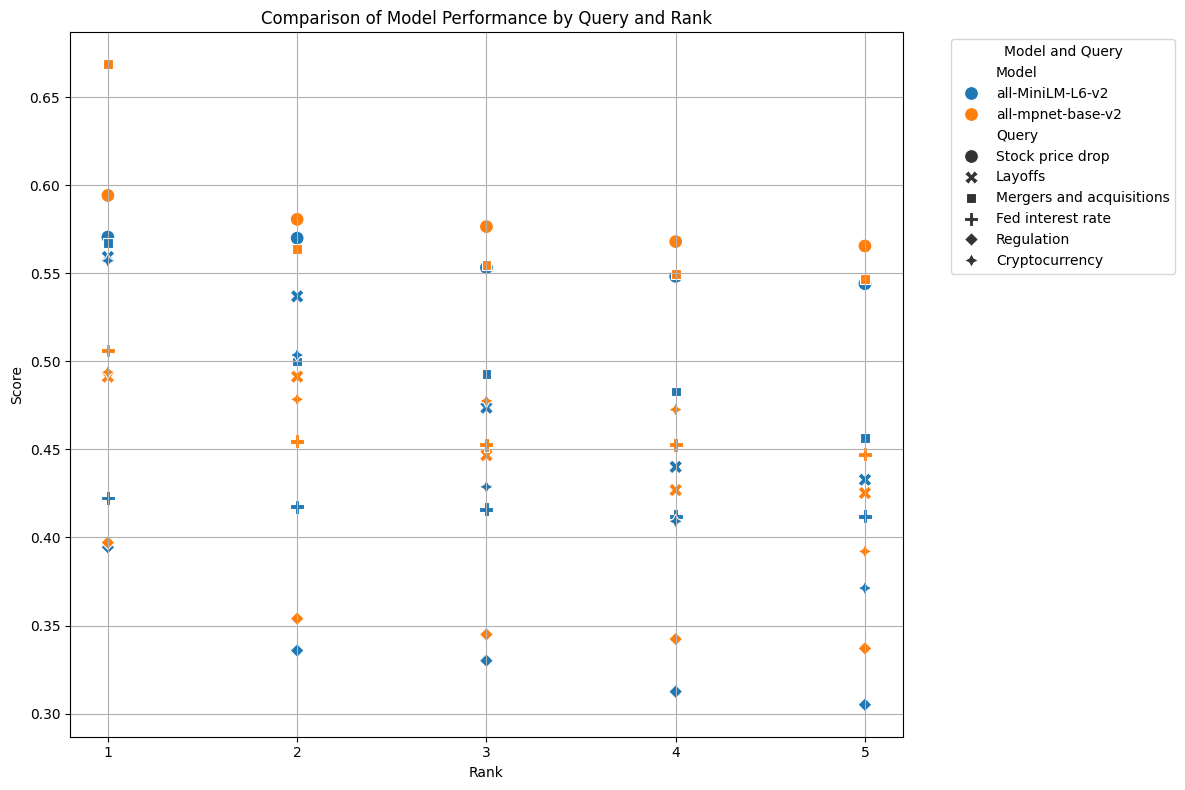

In [ ]:
# Creating a scatter plot to compare the models
plt.figure(figsize=(12, 8))
sns.scatterplot(data=comparison_df, x='Rank', y='Score', hue='Model', style='Query', s=100)

plt.title('Comparison of Model Performance by Query and Rank')
plt.xlabel('Rank')
plt.ylabel('Score')
plt.xticks(range(1, k + 1))
plt.grid(True)
plt.legend(title='Model and Query', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

YOUR WRITTEN RESPONSE HERE

Based on the data from the scatter plot and the table created, the 'all-mpnet-base-v2' model generally performs better. It also has higher similarity scores for top hits for the majority of queries. This is a sign that the returned documents are semantically more appropriate. While 'all-MiniLM-L6-v2' perfoms good, 'all-mpnet-base-v2' better captures query nuances, leading to more highly ranked and relevant hits in this test.


To confirm the finding that 'all-mpnet-base-v2' outperforms, examining some concrete examples from the comparison_df:

* Query: 'Stock price drop'
** 'all-mpnet-base-v2' Rank 1 (HPQ): Score 0.5943
** 'all-MiniLM-L6-v2' Rank 1 (PKG): Score 0.5706
** 'all-mpnet-base-v2' gives a document with a higher similarity score at the top rank.
* Query: 'Mergers and acquisitions'
** 'all-mpnet-base-v2' Rank 1 (TPR): Score 0.6687
** 'all-MiniLM-L6-v2' Rank 1 (KEY): Score 0.5672
** Again, the top result in 'all-mpnet-base-v2' has much higher score.
* Query: 'Fed interest rate'
** 'all-mpnet-base-v2' Rank 1 (JPM): Score 0.5062
** 'all-MiniLM-L6-v2' Rank 1 (DOC): Score 0.4224
** The top result of 'all-mpnet-base-v2' is considerably closer based on the score.


These examples show how 'all-mpnet-base-v2' produces documents with higher similarity scores at the higher ranks compared to 'all-MiniLM-L6-v2' for these given queries, reflecting a superior semantic relevance capturing ability of the query.

## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?

YOUR WRITTEN RESPONSE HERE:
* I equate vector normalization to taking all the documents and search terms to the same "length" in meaning-space. It is totally important because when we calculate how similar something is (cosine similarity), we don't want to measure it by how "loud" they are, but rather how similar their direction is. Normalizing makes the search look for things with the same meanings, like pointing the same direction in that space. For FAISS with IndexFlatIP, this is important since it simply performs a dot product, and that only equals cosine similarity if all's normalized.


### **Q6.**  What would happen if vectors were not normalized before indexing?

YOUR WRITTEN RESPONSE HERE
* If normalized those vectors before indexing, especially with something like FAISS using IndexFlatIP, the similarity scores wouldn't just show how similar the meanings are. The 'length' or 'strength' of the vectors would make things way more complicated. Documents with longer vectors, even though not necessarily the semantically best matches, would possibly rank higher. It would imply that I would not be receiving an actual cosine similarity, and my results would be skewed by how "large" the vectors were, not by meaning.



## 🧠 Critical Thinking / Design Choices


### **Q7.** Which implementation would you choose for a production-scale search system? Why?


YOUR WRITTEN RESPONSE HERE
* if I were coding up a search system for a huge corpus of data, like a million of articles, I'd definitely use the FAISS implementation; while my own worked pretty good, FAISS is intended to be efficient and handle large datasets. It also has advanced methods of vector indexing and searching at lightning-fast speed, which my own simple custom code cannot match when the data sets are humongous. So, in a real-world production system where performance matters, FAISS is the go-to choice.



### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.

YOUR WRITTEN RESPONSE HERE:
* If my database suddenly grew from 5,000 to 5 million articles, FAISS would most certainly scale much better. My own program performs a basic comparison for each document, which becomes extremely slow as the data grows. FAISS would use advanced indexing methods that are capable of searching quickly for similar vectors even in massive datasets.